In [169]:
import gensim
from gensim.models.phrases import Phraser

import pymystem3
import pandas as pd
import scipy.spatial as spatial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [32]:
oc = pd.read_csv('tmp/opencorpora.csv.gz', compression='gzip')
criminal_code = pd.read_csv('tmp/vectors/criminal_code.csv.gz', compression='gzip')
criminal_court_orders = pd.read_csv('tmp/vectors/criminal_court_orders.csv.gz', compression='gzip')
civil_code = pd.read_csv('tmp/vectors/civil_code.csv.gz', compression='gzip')
civil_court_orders = pd.read_csv('tmp/vectors/civil_court_orders.csv.gz', compression='gzip')

oc['source'] = 'opencorpora'
criminal_code['source'] = 'criminal_code'
criminal_court_orders['source'] = 'criminal_court_orders'
civil_code['source'] = 'civil_code'
civil_court_orders['source'] = 'civil_court_orders'

criminal_code['name'] = criminal_code.apply(lambda x: "Ст.{} {}".format(x['article_number'], x['article_name']), axis=1)
civil_code['name'] = civil_code.apply(lambda x: "Ст.{} {}".format(x['article_number'], x['article_name']), axis=1)

civil_court_orders['name'] = ["Гражд. дело {}".format(i) for i in range(civil_court_orders.shape[0])]

In [33]:
tmp = pd.concat([
    oc.reset_index()[['index', 'title', 'lemmas', 'source']].rename(columns={'title':'name'}), 
    criminal_code.reset_index()[['index', 'name', 'lemmas', 'source']],
    criminal_court_orders.reset_index()[['index', 'title', 'lemmas',  'source']].rename(columns={'title':'name'}),
    civil_code.reset_index()[['index', 'name', 'lemmas', 'source']],
    civil_court_orders.reset_index()[['index', 'name', 'lemmas', 'source']],
]).reset_index(drop=True)

In [38]:
%%time
phraser = gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(sentences=tmp['lemmas'].str.split()))

CPU times: user 54.2 s, sys: 2.56 s, total: 56.7 s
Wall time: 56.8 s


In [39]:
criminal_court_orders_train, criminal_court_orders_test = train_test_split(criminal_court_orders, test_size=0.33, random_state=42)

In [40]:
tmp = pd.concat([
    oc.reset_index()[['index', 'title', 'lemmas', 'source']].rename(columns={'title':'name'}), 
    criminal_code.reset_index()[['index', 'name', 'lemmas', 'source']],
    criminal_court_orders_train.reset_index()[['index', 'title', 'lemmas',  'source']].rename(columns={'title':'name'}),
    civil_code.reset_index()[['index', 'name', 'lemmas', 'source']],
    civil_court_orders.reset_index()[['index', 'name', 'lemmas', 'source']],
]).reset_index(drop=True)

In [48]:
gensim.utils.save_as_line_sentence(tmp['lemmas'].map(lambda x: phraser[x.split()]), 'tmp/metrics/phrased.txt')

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(
    documents=gensim.models.doc2vec.TaggedLineDocument('tmp/metrics/phrased.txt'), 
    epochs=500, vector_size=300, workers=4
)

tmp['vectors'] = model.docvecs.vectors_docs.tolist()

In [52]:
model.save('tmp/metrics/all_texts.model')
tmp.to_csv('tmp/metrics/all.csv.gz', index=False, compression='gzip')

Labels for train and test dataset

In [70]:
tmp['label'] = tmp['name'].map(lambda x: x.split()[0].replace("Ст.", ""))
criminal_court_orders_test['labels'] = criminal_court_orders_test['labels'].str.split()

Guess embeddings for test samples

In [93]:
def embed_text(lemmas):
    return model.infer_vector(phraser[lemmas.split()])

In [102]:
from tqdm import tqdm

In [ ]:
vectors = []
for vtext in tqdm(criminal_court_orders_test['lemmas'].tolist()):
    vectors.append(embed_text(vtext))
criminal_court_orders_test['vectors'] = vectors

 12%|█▏        | 695/5594 [06:42<33:34,  2.43it/s]

Creating KDTree from train vectors

In [110]:
len(criminal_court_orders_test.iloc[:804].index)

804

In [120]:
test = criminal_court_orders_test.iloc[:804]

In [184]:
def find_within_radius(embedding, radius):
    neighbours = point_tree.query_ball_point(embedding, radius)
    return neighbours if neighbours else None

In [185]:
code = tmp[tmp['source'] == 'criminal_code'].reset_index(drop=True).copy()

In [186]:
point_tree = spatial.cKDTree(code['vectors'].tolist())

radius: 0	acc: 0.00000	n_size: 0.00000
radius: 5	acc: 0.00000	n_size: 0.00000
radius: 10	acc: 0.00000	n_size: 0.00000
radius: 15	acc: 0.00000	n_size: 0.00000
radius: 20	acc: 0.00000	n_size: 0.00000
radius: 25	acc: 0.00000	n_size: 0.00001
radius: 30	acc: 0.01990	n_size: 0.00521
radius: 35	acc: 0.13184	n_size: 0.06264
radius: 40	acc: 0.37065	n_size: 0.24145
radius: 45	acc: 0.65299	n_size: 0.52406
radius: 50	acc: 0.87065	n_size: 0.77765
radius: 55	acc: 0.96642	n_size: 0.92025
radius: 60	acc: 0.98756	n_size: 0.97217
radius: 65	acc: 0.99378	n_size: 0.99002
radius: 70	acc: 0.99627	n_size: 0.99522
radius: 75	acc: 0.99751	n_size: 0.99719
radius: 80	acc: 0.99876	n_size: 0.99848
radius: 85	acc: 0.99876	n_size: 0.99874
radius: 90	acc: 0.99876	n_size: 0.99876
radius: 95	acc: 1.00000	n_size: 0.99975


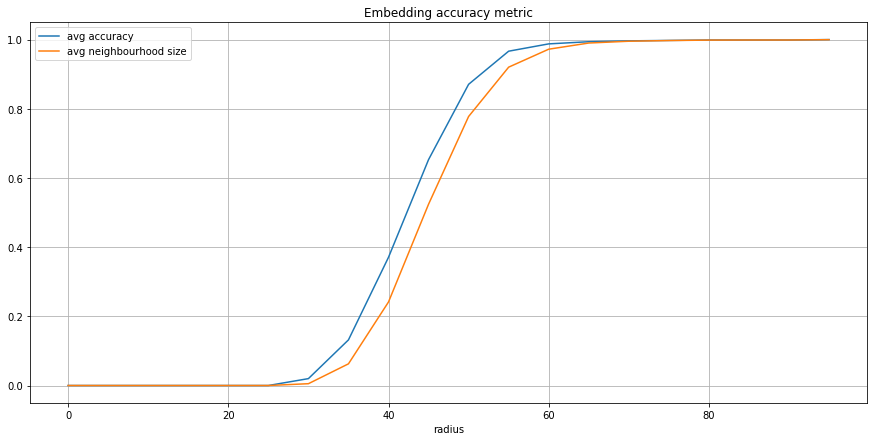

In [190]:
acc = 0
radius = 0
results = {} 
count_neighbours = {}
    
while acc != 1:
    for embedding, labels in test[['vectors', 'labels']].to_records(index=False):
        result = 0
        count = 0
        neighbors = find_within_radius(embedding, radius)
        
        if neighbors:
            count = len(neighbors)
            for neighbour in neighbors:
                if code.loc[neighbour, 'label'] in labels:
                    result = 1
        
        if radius not in count_neighbours:
            count_neighbours[radius] = [count]
        else:
            count_neighbours[radius].append(count)
            
        if radius not in results:
            results[radius] = [result]
        else:
            results[radius].append(result)
    acc = pd.np.mean(results[radius])
    n_size = pd.np.mean(count_neighbours[radius]) / code.shape[0]
    print(f"radius: {radius}\tacc: {acc:.5f}\tn_size: {n_size:.5f}")
    radius += 5
    
plt.figure(figsize=(15, 7))
plt.plot(
    [r for r in results], 
    [pd.np.mean(results[r]) for r in results], 
    label="avg accuracy", #  (mean % matching label found in the neighbourhood)
)
plt.plot(
    [r for r in count_neighbours],
    [pd.np.mean(count_neighbours[r]) / code.shape[0] for r in count_neighbours],
    label="avg neighbourhood size", # (mean size of the neighbourhood in % from all samples),
)
plt.title("Embedding perfomance")
plt.legend(loc="best")
plt.xlabel("radius")
plt.grid()
plt.show()